# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

It Works with the dependencies below:

In [ ]:
!pip install --upgrade pip tensorflow tensorflow-gpu==2.10.0 labelme opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [9]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Collected 210 real images

### 1.3 Annotate Images with LabelMe

In [10]:
!labelme

Annotated (with label "face") the images where the face is present and labeled them with a rectangle.

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TensorFlow and Dependencies

In [11]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 2.3 Load Image into TensorFlow Data Pipeline

In [15]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [16]:
images.as_numpy_iterator().next()

b'data\\images\\00126649-709d-11ed-beaa-b4d5bde1051d.jpg'

Function that gets a path, generate the bytecode of the image and decoded it getting the image as tensorflow pipeline

In [17]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [18]:
images = images.map(load_image)

In [19]:
images.as_numpy_iterator().next()

array([[[113, 136, 120],
        [113, 134, 119],
        [115, 131, 118],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[118, 139, 124],
        [116, 137, 122],
        [121, 135, 122],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[116, 134, 118],
        [116, 134, 118],
        [121, 133, 119],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       ...,

       [[166, 171, 174],
        [167, 172, 175],
        [170, 175, 178],
        ...,
        [ 54,  80,  93],
        [ 52,  80,  92],
        [ 49,  77,  89]],

       [[172, 177, 180],
        [172, 177, 180],
        [174, 179, 182],
        ...,
        [ 52,  78,  91],
        [ 57,  83,  98],
        [ 56,  82,  97]],

       [[174, 179, 182],
        [173, 178, 181],
        [175, 180, 183],
        ...,
        [ 53,  79,  92],
        [ 58,  84,  99],
        [ 55,  81,  96]]

In [20]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

I can collect 4 images at a time, put 4 in each batch

In [24]:
image_generator = images.batch(4).as_numpy_iterator()

To get the next batch

In [49]:
plot_images = image_generator.next()

Loop and visualize the images, every run of .next() generate a batch of 4 images printed below, they are 4 consecutive images because of the shuffle=False when loading images. If you want 4 images shuffled you can delete shuffle=False in loading images row.

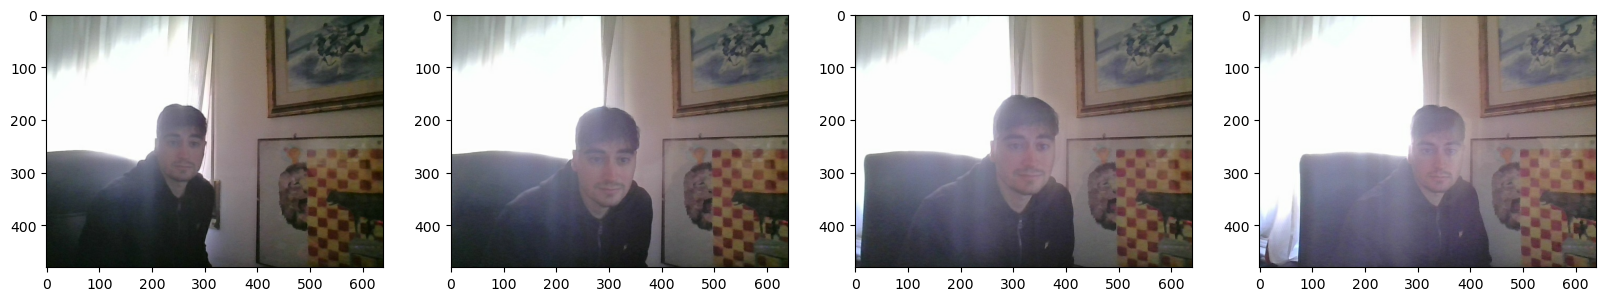

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLIT DATA INTO TRAIN TEST AND VAL

I have taken 210 images and then 70 % for train 15% for val and 15% for test

In [51]:
210*0.7 #147 for train

147.0

In [53]:
210*0.15 #32 for test and 31 for validation

31.5

### 3.2 Move the Matching Labels

I have manually picked 147 images and cut them into the "images" folder in the "train" folder, I've done the same thing for "val" and "test" folder (31 and 32 images), now I'll bring the respective labels into the "labels" folder of the "train", "test", "val" folders (this step is automatic and it's written below).
The image identified by "345484" and in "images" folder of the "train" folder will have the corresponding label in "labels" folder of the "train" folder.

In [54]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline 

In [55]:
import albumentations as alb

I will apply 6 types of augmentation

In [56]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

RandomCrop get images with 450*450 size so will cut them a little bit (you can see the real image size below (480 * 640) ).

The formats are important, in my case I've used "albumentations" who does a normalization so it will scale images in a value between 0 and 1. For example "pascal_voc" format doesn't scale, the label (rectangle) coordinates remains as the original ones.

Examples to show how it works on an image

### 4.2 Load a Test Image and Annotation with OpenCV and JSON 

In [68]:
img = cv2.imread(os.path.join('data', 'train', 'images', '0155a4cb-709d-11ed-a60a-b4d5bde1051d.jpg'))

In [69]:
img

array([[[111, 125, 121],
        [111, 125, 121],
        [111, 124, 122],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[113, 127, 123],
        [114, 128, 124],
        [113, 126, 124],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[115, 126, 123],
        [117, 128, 125],
        [115, 128, 126],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       ...,

       [[171, 169, 169],
        [173, 171, 171],
        [180, 175, 176],
        ...,
        [251, 255, 214],
        [251, 255, 213],
        [250, 254, 212]],

       [[176, 173, 175],
        [179, 177, 177],
        [183, 178, 179],
        ...,
        [251, 255, 214],
        [251, 255, 213],
        [250, 254, 212]],

       [[179, 176, 178],
        [183, 180, 182],
        [184, 179, 180],
        ...,
        [251, 255, 214],
        [250, 254, 212],
        [249, 253, 211]]

In [70]:
img.shape

(480, 640, 3)

480 height, 640 width, 3 channels deep

Get the label of the image above

In [71]:
with open(os.path.join('data', 'train', 'labels', '0155a4cb-709d-11ed-a60a-b4d5bde1051d.json'), 'r') as f:
    label = json.load(f)

In [72]:
type(label)

dict

In [73]:
label

{'version': '5.1.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[260.8212560386474, 187.34299516908212],
    [378.69565217391306, 320.67632850241546]],
   'group_id': None,
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\0155a4cb-709d-11ed-a60a-b4d5bde1051d.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZ

In [74]:
label['shapes'][0]

{'label': 'face',
 'points': [[260.8212560386474, 187.34299516908212],
  [378.69565217391306, 320.67632850241546]],
 'group_id': None,
 'shape_type': 'rectangle',
 'flags': {}}

In [75]:
label['shapes'][0]['label']

'face'

In [76]:
label['shapes'][0]['points']

[[260.8212560386474, 187.34299516908212],
 [378.69565217391306, 320.67632850241546]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution 

In [77]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [78]:
coords

[260.8212560386474, 187.34299516908212, 378.69565217391306, 320.67632850241546]

The coordinates are: x1, y1, x2, y2

Divides the coordinates of the rectangle above with the image size so width (640) for x1 and x2 who represent the width and height (480) for y1 and y2 who represent the height.

In [79]:
coords = list(np.divide(coords, [640,480,640,480]))

In [80]:
coords

[0.40753321256038655,
 0.3902979066022544,
 0.5917119565217391,
 0.6680756843800322]

From "pascal_voc" format to "albumentations" format, values between 0 and 1 (normalized).

### 4.4 Apply Augmentations and View Results 

In [81]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [82]:
type(augmented)

dict

In [83]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [84]:
augmented['image'].shape

(450, 450, 3)

In [85]:
augmented['bboxes']

[(0.4628985507246376,
  0.36076221148684917,
  0.7248416532474502,
  0.6570585077831455)]

The first two values correspond to x1, y1

In [86]:
augmented['bboxes'][0][:2]

(0.4628985507246376, 0.36076221148684917)

The last two values correspond to x2, y2

In [87]:
augmented['bboxes'][0][2:]

(0.7248416532474502, 0.6570585077831455)

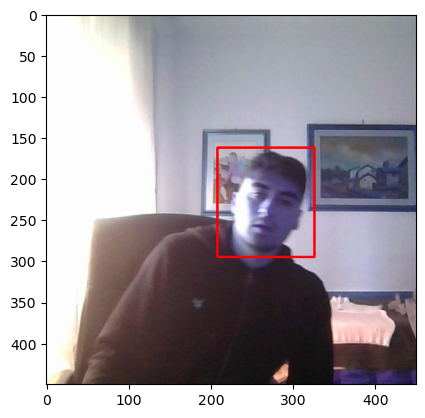

In [88]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline 

Loop to train, test and validation folders and grab every image inside that.

We'll check if an annotation exists or not for that image

If an annotation (the rectangle) doesn't exist we'll create a default annotation " coords = [0,0,0.00001,0.00001]"

If the annotation exists do the transformation explained below so extract coordinates and rescale to match the image resolution.

We'll create 90 images per image and put them inside a folder called "aug_data" and generate labels (annotation) in json.

In [89]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(90):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.5479317632850242, 0.24033816425120771, 0.35695954106280203, 0.003824476650563562, 'face'].
x_max is less than or equal to x_min for bbox [0.4498037439613527, 0.3218599033816425, 0.30865036231884063, 0.09138486312399352, 'face'].
x_max is less than or equal to x_min for bbox [0.43999094202898553, 0.32085346215781, 0.3373339371980677, 0.1396940418679549, 'face'].
x_max is less than or equal to x_min for bbox [0.6196407004830918, 0.6892109500805152, 0.4052687198067633, 0.35607890499194844, 'face'].
x_max is less than or equal to x_min for bbox [0.5675573671497586, 0.6177536231884059, 0.4037590579710145, 0.34098228663446056, 'face'].
x_max is less than or equal to x_min for bbox [0.741923309178744, 0.4386070853462158, 0.45584239130434784, 0.0018115942028985052, 'face'].
x_max is less than or equal to x_min for bbox [0.5471769323671498, 0.5865539452495975, 0.3690368357487923, 0.30877616747181963, 'face'].
x_max is less than or equal to x_min 

### 5.2 Load Augmented Images to Tensorflow Dataset 

As we can see below, images are compressed in 120x120 to make the neural newtork works fine.

In this case the shuffle has to be False because I have to mantain the order for labels.

In [90]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [91]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [92]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [93]:
train_images.as_numpy_iterator().next()

array([[[0.05637255, 0.1504902 , 0.09803922],
        [0.06501225, 0.1591299 , 0.10637255],
        [0.05508579, 0.15851715, 0.10459559],
        ...,
        [0.09313726, 0.23431373, 0.1872549 ],
        [0.08707108, 0.23547794, 0.18382353],
        [0.09944853, 0.25030637, 0.20226716]],

       [[0.06188725, 0.1560049 , 0.09754902],
        [0.05490196, 0.14901961, 0.08713235],
        [0.04901961, 0.15343137, 0.09509804],
        ...,
        [0.09908088, 0.24810049, 0.1971201 ],
        [0.0935049 , 0.25300246, 0.19767156],
        [0.10490196, 0.2617647 , 0.22892156]],

       [[0.06041666, 0.16629902, 0.09963235],
        [0.06433824, 0.16875   , 0.10257353],
        [0.06023284, 0.15435049, 0.09944853],
        ...,
        [0.09056372, 0.23958333, 0.19644608],
        [0.10153186, 0.25888482, 0.21427695],
        [0.10606617, 0.26292893, 0.2276348 ]],

       ...,

       [[0.47224265, 0.5663603 , 0.428125  ],
        [0.47444853, 0.5685662 , 0.44209558],
        [0.47058824, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [94]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [95]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [96]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [97]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [100]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

I have an array with 2 elements: the class and the 4 coordinates

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths 

In [101]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(12150, 12150, 2520, 2520, 2250, 2250)

12150 Images and labels for training, 2520 for test and 2250 for validation, we started with 210 "real" images and now we have got more than 15k images. 

### 7.2 Create Final Datasets (Images/Labels)

In [102]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [103]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [104]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

We used the "zip" method to combine images with labels after we did a shuffle with size bigger than the size of the dataset and every batch is represented by 8 images and 8 labels and prefatch eliminates bottlenecks when you loading and training the data 

In [105]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

8 Images with 120 pixels of width and 120 pixels of height and 3 channels because they are coloured images.

In [106]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.5513, 0.347 , 0.857 , 0.745 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.4243, 0.2957, 0.7573, 0.6704],
        [0.2094, 0.2815, 0.5356, 0.726 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.4863, 0.628 , 0.659 , 0.8394],
        [0.3025, 0.3318, 0.6484, 0.703 ],
        [0.2817, 0.3577, 0.571 , 0.7217]], dtype=float16))

It returns labels (8 labels because 8 is the batch size), with different classes (0 or 1) and bounding boxes.

### 7.3 View Images and Annotations

In [107]:
data_samples = train.as_numpy_iterator()

Get the next batch and plot it out

In [148]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


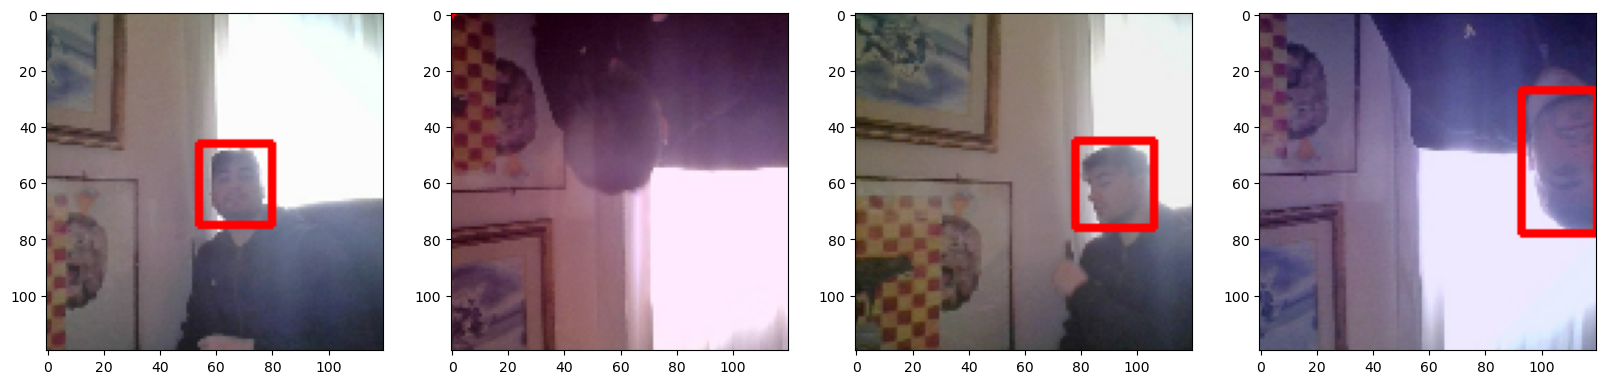

In [149]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

We can see images annotated and augmented!
Run the "next" function many times to get differents batches

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [150]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16 

In [151]:
vgg = VGG16(include_top=False)

In [152]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

VGG is a classification model and is built as image classification, and the summary describe what the neural network looks like.

The "None" value represents the original value: so (None, None, None, 256) represents: 120, 120, 3 which are width height and channels and the 256 layers (kernels).

We have convolutions and poolings.

### 8.3 Build instance of Network

In [153]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

We have an input layer and an output. The input seems to be an image, the outputs are 2: classification output and regression output.

We create the VGG16 layer. Pass the input_layer to the vgg layer.

Condensing all the informations of our VGG layer in the global max pooling layer, this layer is passed in our fully connected layer (the Dense). So the f1 who reprsents the VGG16 output is passed into the Dense layer who has 2048 units with an activation "Relu" and this is stored in th "class1" which is passed into the next layer to get the class2.

The classification output should be only one value (one output) as we can see when we create class2 variable, there's only one Dense as sigmoid so the value could only be between 0 and 1.

The second output which is "regression" has 4 outputs (4 points of rectangle) between 0 and 1.

The classification output are 0 or 1 and regression output is the values of the points of rectangle, look below:

In [154]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3723, 0.3826, 0.5645, 0.59  ],
        [0.315 , 0.583 , 0.598 , 0.917 ],
        [0.5596, 0.3274, 0.822 , 0.6235],
        [0.6807, 0.3994, 0.8994, 0.641 ],
        [0.3035, 0.4006, 0.5195, 0.653 ],
        [0.2161, 0.3354, 0.505 , 0.699 ],
        [0.517 , 0.3696, 0.8296, 0.767 ],
        [0.2559, 0.3354, 0.59  , 0.707 ]], dtype=float16))

### 8.4 Test out Neural Network

In [155]:
facetracker = build_model()

In [156]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

The cell above describes the neural network

Starts with input_layer, pass it through vgg 16, after pass it through global_max_pooling and reduce the output shape from (None, None, None, 512) to 2 values with the shape: (None, 512).

These 2 values are passed to dense layers: the first one is passed to a dense layer ("dense") and after to another dense layer ("dense_1") which is used for classifiying. The second max_pooling is passed through a dense layer ("dense_2") and after through ("dense_3") to get the regression values.

The entire neural network has 16.8 million params.

Example of the training pipeline (X will be for images, y for labels):

In [157]:
X, y = train.as_numpy_iterator().next()

In [158]:
X

array([[[[0.14871323, 0.1721201 , 0.23357843],
         [0.1367647 , 0.14362745, 0.19411765],
         [0.11458334, 0.10772059, 0.14056373],
         ...,
         [0.26770833, 0.26023284, 0.23866421],
         [0.3992647 , 0.36102942, 0.31446078],
         [0.47996324, 0.40251225, 0.35245097]],

        [[0.15931372, 0.15490197, 0.20931372],
         [0.19466911, 0.17843138, 0.23106618],
         [0.19718137, 0.16881128, 0.2016544 ],
         ...,
         [0.23100491, 0.20955883, 0.1860294 ],
         [0.32591912, 0.28762254, 0.25232843],
         [0.4175858 , 0.36936274, 0.32971814]],

        [[0.17493872, 0.16807598, 0.19344363],
         [0.2148897 , 0.17653187, 0.21096814],
         [0.22506127, 0.16519608, 0.20343137],
         ...,
         [0.290625  , 0.26317403, 0.2396446 ],
         [0.30631128, 0.2788603 , 0.24834558],
         [0.3283701 , 0.29601717, 0.26182598]],

        ...,

        [[0.60637254, 0.64166665, 0.6220588 ],
         [0.6227328 , 0.6585172 , 0.64773285]

In [159]:
y

(array([[1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0]], dtype=uint8),
 array([[0.4233 , 0.3926 , 0.65   , 0.6816 ],
        [0.543  , 0.4011 , 0.7974 , 0.676  ],
        [0.4912 , 0.3123 , 0.7993 , 0.6646 ],
        [0.06836, 0.0651 , 0.3518 , 0.399  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.5835 , 0.372  , 0.882  , 0.7383 ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

In [160]:
X.shape

(8, 120, 120, 3)

Pass "X" to our facetracker model:

In [161]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 5s 5s/step


In [162]:
classes, coords

(array([[0.41765088],
        [0.47474933],
        [0.51738906],
        [0.4654182 ],
        [0.4742823 ],
        [0.4710773 ],
        [0.47872308],
        [0.5422605 ]], dtype=float32),
 array([[0.57989675, 0.2717193 , 0.23400915, 0.3109556 ],
        [0.4943916 , 0.2796914 , 0.3714727 , 0.34488872],
        [0.49240127, 0.37904966, 0.38825867, 0.4168048 ],
        [0.55907816, 0.26818228, 0.37420136, 0.4119686 ],
        [0.5412699 , 0.26331398, 0.37781498, 0.3867439 ],
        [0.56859654, 0.32312897, 0.32882544, 0.4039743 ],
        [0.5532022 , 0.31615886, 0.373608  , 0.39944524],
        [0.60375065, 0.33434248, 0.34697878, 0.357314  ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR 

In [163]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [164]:
lr_decay

0.00021944261575597976

lr_decay specifies how to reduce the learning rate, the 75% of the original learning rate every epoch, we'll slow down the learning to avoid the overfit and to don't blow out the gradient

In [165]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

### 9.2 Create Localization Loss and Classification Loss

In [166]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

Get the distance between the actual and predicted coordinates, we square the difference and summing all together.

Then we calculate the actual height and width of the box and the predicted ones.

We do the same thing of before but focusing on the size (not coordinates)

Using the coordinates and sizes we can have the localization loss

In [167]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics 

Test it out:

localization_loss passing the bounding box coordinates (y[1]) and the coordinates (coords)

In [168]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.1946383>

To get the actual value:

In [169]:
regressloss(y[1], coords).numpy()

3.1946383

Now test out the classification loss

In [170]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.72998095>

In [171]:
classloss(y[0], classes).numpy()

0.72998095

# 10. Train Neural Network

### 10.1 Create Custom Model Class 

In [172]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

When you create a model class from Keras you need to have an "init" method, a "compile" method, a "train_step" method and a "call" method.

The "init" method gets the initial params, in our case we pass a pre-built neural network which is "eyetracker" which is our (faceTracker model)

Then "compile" it passing our loss and optimizer.

The "train_step" gets one batch of data and it's going to train on that batch of data. We get that batch of data and unpacks it in X and y, pass the X through our model ("facetracker") and get class and coords.

These class and coords we'll be passed through the respective loss functions.

The classification loss function who gets the "y[0]" so the classification value (is the y_true) and "classes" so the predicted value (the y_pred)

The localization (regression) loss function gets the "real" coords and the predicted coords.

When we got both losses we sum them to get "total_loss"

Calculate the gradient: pass it the total_loss, get the gradient for each variable and after apply the optimization to reduce the loss

After the "train_step" returns the losses.

Then we have "test_step" that is identical to "train_step".

The "call" method is a must if you want to call the "predict" method.

In [173]:
model = FaceTracker(facetracker)

In [174]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

We'll specify the directory for logs

In [175]:
logdir='logs'

If you want to review your model performance:

In [176]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [177]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
1519/1519 [==============================] - 331s 208ms/step - total_loss: 0.7233 - class_loss: 0.3450 - regress_loss: 0.5508 - val_total_loss: 1.4731 - val_class_loss: 2.0509 - val_regress_loss: 0.4477
Epoch 2/10
1519/1519 [==============================] - 279s 178ms/step - total_loss: 0.3435 - class_loss: 0.1822 - regress_loss: 0.2524 - val_total_loss: 0.4320 - val_class_loss: 0.5063 - val_regress_loss: 0.1789
Epoch 3/10
1519/1519 [==============================] - 312s 199ms/step - total_loss: 0.2750 - class_loss: 0.1465 - regress_loss: 0.2017 - val_total_loss: 1.3671 - val_class_loss: 1.7081 - val_regress_loss: 0.5130
Epoch 4/10
1519/1519 [==============================] - 333s 210ms/step - total_loss: 0.2463 - class_loss: 0.1324 - regress_loss: 0.1801 - val_total_loss: 3.1889 - val_class_loss: 5.0700 - val_regress_loss: 0.6539
Epoch 5/10
1519/1519 [==============================] - 334s 210ms/step - total_loss: 0.2442 - class_loss: 0.1304 - regress_loss: 0.1790 - val_t

"model.fit" calls the model "FaceTracker" and does the "train_step" and if we pass through the validation data he does the "test_step"

"hist" gets the history.

### 10.3 Plot Performance

In [178]:
hist.history

{'total_loss': [0.10464011877775192,
  0.2132396548986435,
  0.009955096058547497,
  0.7302349805831909,
  0.22862014174461365,
  0.04065844416618347,
  0.14528506994247437,
  0.26950937509536743,
  0.011747550219297409,
  0.4288255274295807],
 'class_loss': [0.052960556000471115,
  0.1041017398238182,
  0.008463727310299873,
  0.47245335578918457,
  0.1548198014497757,
  0.04015691205859184,
  0.11393854767084122,
  0.12380450963973999,
  0.011363123543560505,
  0.14234896004199982],
 'regress_loss': [0.07815983891487122,
  0.1611887812614441,
  0.00572323240339756,
  0.49400827288627625,
  0.1512102484703064,
  0.0205799899995327,
  0.08831579983234406,
  0.20760712027549744,
  0.006065988447517157,
  0.3576510548591614],
 'val_total_loss': [1.4731383323669434,
  0.43204838037490845,
  1.3670707941055298,
  3.1889374256134033,
  1.7329307794570923,
  0.24061262607574463,
  2.8193984031677246,
  0.0019638717640191317,
  1.912096877276781e-06,
  0.01060557086020708],
 'val_class_loss':

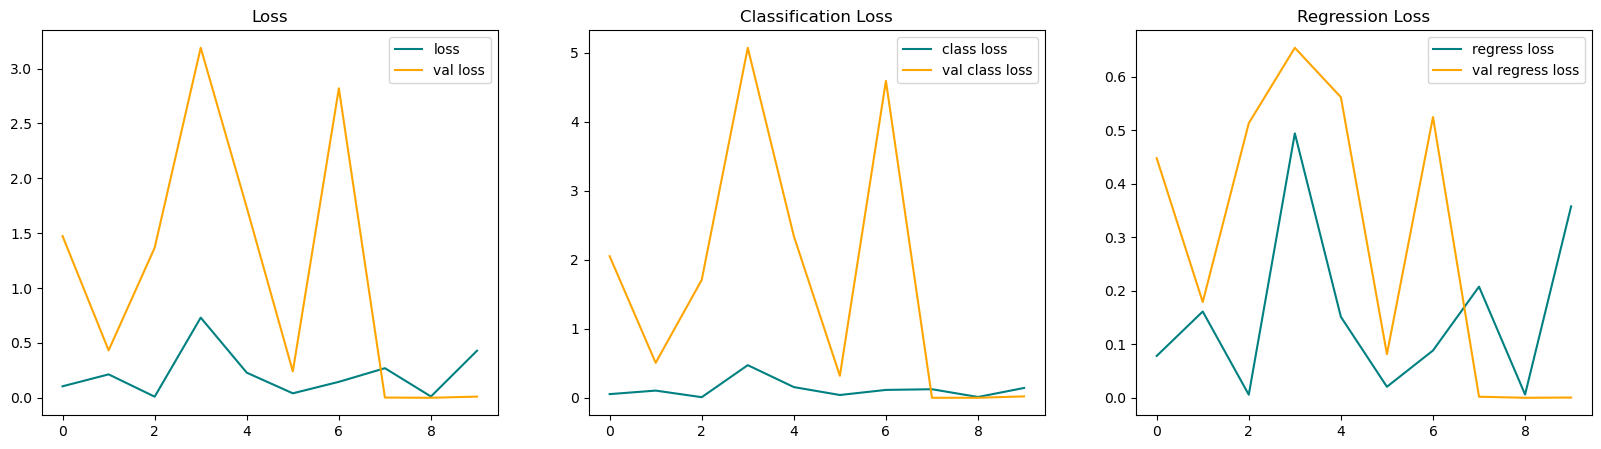

In [179]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

We can see that regression loss bounces up and down, may is because validation data are weird and incorrect.

The classification goes perfectly

# 11. Make Predictions

### 11.1 Make Predictions on Test Set 

In [180]:
test_data = test.as_numpy_iterator()

In [246]:
test_sample = test_data.next()

I get one batch who has 8 images

In [247]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


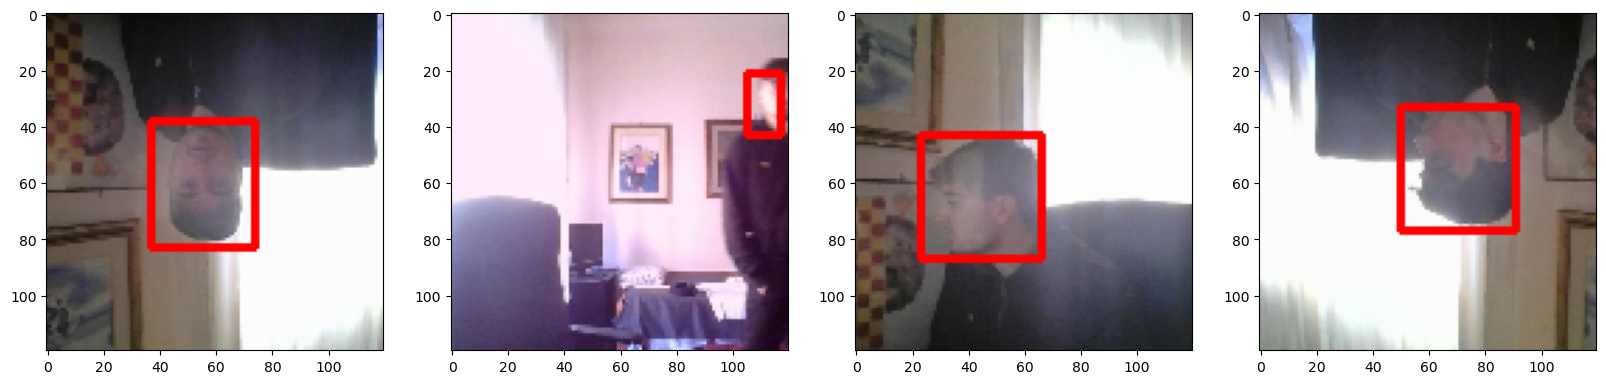

In [248]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

Draw the rectangle only if the value is bigger than 0.9

### 11.2 Save the Model

In [249]:
from tensorflow.keras.models import load_model

In [250]:
facetracker.save('facetracker.h5')

In [251]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

We capture our video frame, convert it from BGR to RGB because OpenCV reads it in BGR and tensorflow needs RGB. Resize dividing with 120 and rescale it down and predict.

In [252]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


This one above opens a popup with the camera and the label to recognize the face, "q" to close it